In [1]:
import os
os.chdir('../')

In [26]:
from utils import *
from loader import *

logging.disable(logging.CRITICAL)

from PCAfold import compute_normalized_variance, cost_function_normalized_variance_derivative, KReg
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.ticker as mticker
import matplotlib.patches as patches
import matplotlib.cm as cm
from matplotlib.ticker import ScalarFormatter

# Figure 4: Sparsification of the optimized PV</br>
Analysis on how the f-PV parametrization changes when the optimized PV is sparsified.

In [3]:
def compute_avg(costs):
    n = len(costs)
    sum = np.sum(costs**2)
    return 1/n*np.sqrt(sum)

In [4]:
path_data = "data-files/"
filename_species_names = "Xu-state-space-names.csv"
path_metadata = "metadata/"

penalty_function = 'log-sigma-over-peak'
start_bw = -6
end_bw = 2
nbr_points_bw = 100
bandwidth_values = np.logspace(start_bw, end_bw, nbr_points_bw)
power = 1
vertical_shift = 1

my_seed = 7
neighbours = [5, 10, 15, 20, 25]

***
<h2> Autoignition case

In [ ]:
path_state = path_data + "Xu-state-space-autoignition.csv"

filename_model = "Xu-AE-opt_adam-epo_100000-lr_0.025-date_24Mar2025-hour_10h50_Tr0D-2s_s2" #"Xu-AE-opt_adam-epo_100000-lr_0.025-date_14Mar2025-hour_14h23_Tr0D-2q_s0"
filename_metadata_0D = filename_model + "_metadata.pkl"

loader_0D = loadData(filename_species_names, path_metadata, filename_metadata_0D)
output_idx = loader_0D.metadata["list idx species removed source"] if loader_0D.metadata["dataset_type"].startswith("autoignition_augm") else loader_0D.metadata["idx species removed"]
idx_species_removed = loader_0D.metadata["list idx species removed source"] if loader_0D.metadata["dataset_type"].startswith("autoignition_augm") else loader_0D.metadata["idx species removed"]
input_scaling = loader_0D.metadata["input scaling"]
input_species_scaling = loader_0D.metadata["input species scaling"]
input_species_bias = loader_0D.metadata["input species bias"]
range_mf  = loader_0D.metadata["range_mf"]
depvar_names_species = loader_0D.metadata["list species output"]
depvar_names_idx = loader_0D.metadata["output elements"]
PV_dim = loader_0D.metadata["PV dim"]
depvar_names = depvar_names_species + depvar_names_idx[-(PV_dim+1):]
model_0D = loader_0D.loadModel()
id = loader_0D.metadata["Training_id"]
nbr_input_species = loader_0D.metadata["nbr input species"]

print(idx_species_removed)

species = Species(path_data)
list_all_species = species.get_list_species()
list_input_species = [item for idx, item in enumerate(list_all_species) if idx not in idx_species_removed]
print(list_input_species)

cost_array = []
MSE_kr_array = []
order_species_removed_0D = []

compute_cost = False
compute_Kreg = False

nbr_observations = 10
sample_dataset = True

for i in range(nbr_input_species): #nbr_input_species):
    final_weights = model_0D.get_total_encoder_weights(npy = True)[0]

    #get index spcies removed
    my_species = Species(path_data)
    
    list_species = my_species.get_list_species()
    for index in sorted(idx_species_removed, reverse=True):
        list_species.pop(index)

    #get mass fractions of species
    state_space = read_csv(path_state, header = "infer")
    state_space = state_space.drop(state_space.columns[idx_species_removed], axis=1)
    state_space_matrix = state_space.to_numpy()

    wi_Yi = state_space_matrix*np.abs(final_weights) #|w_i|*Y_i
    max_wi_Yi = np.max(wi_Yi, axis = 0) #take max of every species

    #selection of values greater than zero
    #CHECK that none of the weights in the PV is already zero!
    mask = max_wi_Yi > 0

    #Find the index with the minimum max wi Yi which is not zero
    index_species_min_max_wi_Yi = np.argmin(max_wi_Yi[mask])

    #Get the index back in the original array
    index_species_min_max_wi_Yi = np.where(mask)[0][index_species_min_max_wi_Yi]
    
    if(i>0): #do not simplify for the first iteration to have the first value with all input species
        with torch.no_grad():
            model_0D.encoder_species.weight[0,index_species_min_max_wi_Yi] = 0
            order_species_removed_0D.append(list_input_species[index_species_min_max_wi_Yi])


    ##########################
    #Compute the manifold cost
    ##########################
    
    #get the input (PV and f) and the output (interested Yi, T and source terms) data
    input, output = get_dataset(path_data + "Xu-state-space-autoignition.csv", path_data + "Xu-state-space_source-autoignition.csv", path_data + "Xu-T-autoignition.csv",
                                path_data + "Xu-mf-autoignition.csv", output_idx, idx_species_removed, input_scaling, input_species_scaling, input_species_bias, range_mf)
    
    if(sample_dataset):
        #sample to speed up the tests
        torch.manual_seed(my_seed)
        indices = torch.randint(0, input.size(0), (nbr_observations,)) #set here the number of observations sampled, previous version was with 10k observations (?)
        input = input[indices]
        output = output[indices]
    

    PV = model_0D.get_PV(input)
    PV_f = torch.cat((PV, input[:, -1].reshape(-1, 1)), dim = 1) #reshape to be (5200,1) instead of (52000)
    output = model_0D.get_source_PV(output, input_species_scaling)

    #scale every column of the PV_f tensor between 0 and 1
    min_vals = PV_f.min(dim=0, keepdim=True).values
    max_vals = PV_f.max(dim=0, keepdim=True).values
    PV_f_scaled = (PV_f - min_vals) / (max_vals - min_vals)

    indepVars = PV_f_scaled.detach().numpy()
    depVars = output.detach().numpy()
    
    if(compute_cost):
        #Compute the cost
        variance_data = compute_normalized_variance(indepVars,
                                                    depVars,
                                                    depvar_names=depvar_names,
                                                    bandwidth_values=bandwidth_values)
        costs = cost_function_normalized_variance_derivative(variance_data,
                                                            penalty_function=penalty_function,
                                                            power=power,
                                                            vertical_shift=vertical_shift,
                                                            norm=None)
        print(f"{np.round(compute_avg(np.array(costs)),3)}")
        cost_array.append(compute_avg(np.array(costs)))
    

    #####################
    #Compute the Kreg MSE
    #####################

    mse_values_model = np.zeros(len(neighbours))

    min_output = output.min(dim=0, keepdim=True)[0]  # Minimum values for each column
    max_output = output.max(dim=0, keepdim=True)[0]  # Maximum values for each column

    output_scaled = (output - min_output) / (max_output - min_output)

    #create training and validation datasets
    np.random.seed(my_seed)
    nbr_observations = PV_f_scaled.shape[0]
    indices = np.arange(nbr_observations)
    nbr_train = int(nbr_observations*0.8)
    sampled_indices = np.random.choice(indices, size=nbr_train, replace=False)
    validation_indices = np.setdiff1d(indices, sampled_indices)

    input_model = PV_f_scaled.detach().numpy()
    output_model = output_scaled.detach().numpy()

    if(compute_Kreg):
        for j, neighbour in enumerate(neighbours):

            query = input_model[validation_indices,:]

            kernel_model = KReg(input_model[sampled_indices, :], output_model[sampled_indices, :])
            predicted_model = kernel_model.predict(query, 'nearest_neighbors_isotropic', n_neighbors=neighbour)

            squared_error_model = (predicted_model - output_model[validation_indices,:]) ** 2
            mse_model = np.mean(squared_error_model)
            mse_values_model[j] = mse_model

        avg_mse = np.mean(mse_values_model)
        std_mse = np.std(mse_values_model)

        print(f"{round(avg_mse*10000,3)} (\u00B1 {round(std_mse*10000, 3)})")

        MSE_kr_array.append(avg_mse)

#add the last species into the list of removed species
tensor = model_0D.encoder_species.weight[0, :]
non_zero_indices = torch.nonzero(tensor, as_tuple=True)
print(f"non zero indices in tuple {non_zero_indices}")
non_zero_indices_list = non_zero_indices[0].tolist()
print(f"last element to add {non_zero_indices_list}")
order_species_removed_0D.append(list_input_species[non_zero_indices_list[0]])

[9, 11]
['H2NN', 'H2O2', 'H2O', 'H2', 'HNO', 'HO2', 'HONO2', 'HONO', 'H', 'N2O', 'NH2', 'NH', 'NNH', 'NO2', 'NO', 'N', 'O2', 'OH', 'O']
non zero indices in tuple (tensor([2]),)
last element to add [2]


In [6]:
# For 0D-2s_s2

MSE_NN_array_autoignition = np.load("paper/data/MSE_val_NN_Tr0D-2s_autoignition_s7_lr0.01_scaleManifoldTrue_PV_simplification.npy")
MSE_NN_PV_array_autoignition = np.load("paper/data/MSE_PVsource_val_NN_Tr0D-2s_autoignition_scaleManifoldTrue_PV_simplification.npy")

cost_array_pow4_autoignition = np.load("paper/data/cost_list_Tr0D-2s_s2_low_PV_simplification_pow4_autoignition.npy")
costPV_array_pow4_autoignition = np.load("paper/data/costPV_list_Tr0D-2s_s2_low_PV_simplification_pow4_autoignition.npy")

## With MSE NN values

### Manifolds 0D when sparsifying with different species

In [7]:
filename_autoignition = "isochoric-adiabatic-closed-HR-H2-air-lin_Z_0.015_0.035_100-T0_900-"
path_data_autoignition = "data-files/autoignition/"
path_data = "data-files/"

#create all the datasets
mixture_fractions_train_0D = np.loadtxt(f"{path_data_autoignition}{filename_autoignition}mixture-fraction.csv") #1 x nbr_timesteps
mixture_fractions_test_0D = np.loadtxt(f"{path_data_autoignition}{filename_autoignition}mixture-fractions-test-trajectories.csv") #1 x nbr_test_trajectories
state_space_names = np.genfromtxt(f"{path_data_autoignition}{filename_autoignition}state-space-names.csv", delimiter=",", dtype=str)
state_space_train_0D = pd.read_csv(f"{path_data_autoignition}{filename_autoignition}state-space.csv", names = state_space_names)
state_space_source_train_0D = pd.read_csv(f"{path_data_autoignition}{filename_autoignition}state-space-sources.csv", names = state_space_names)
time_train = np.loadtxt(f"{path_data_autoignition}{filename_autoignition}time.csv") #1 x nbr_timesteps

C:\Windows\Temp\ipykernel_39600\837556010.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  greys = cm.get_cmap('Greys')
C:\Windows\Temp\ipykernel_39600\837556010.py:471: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


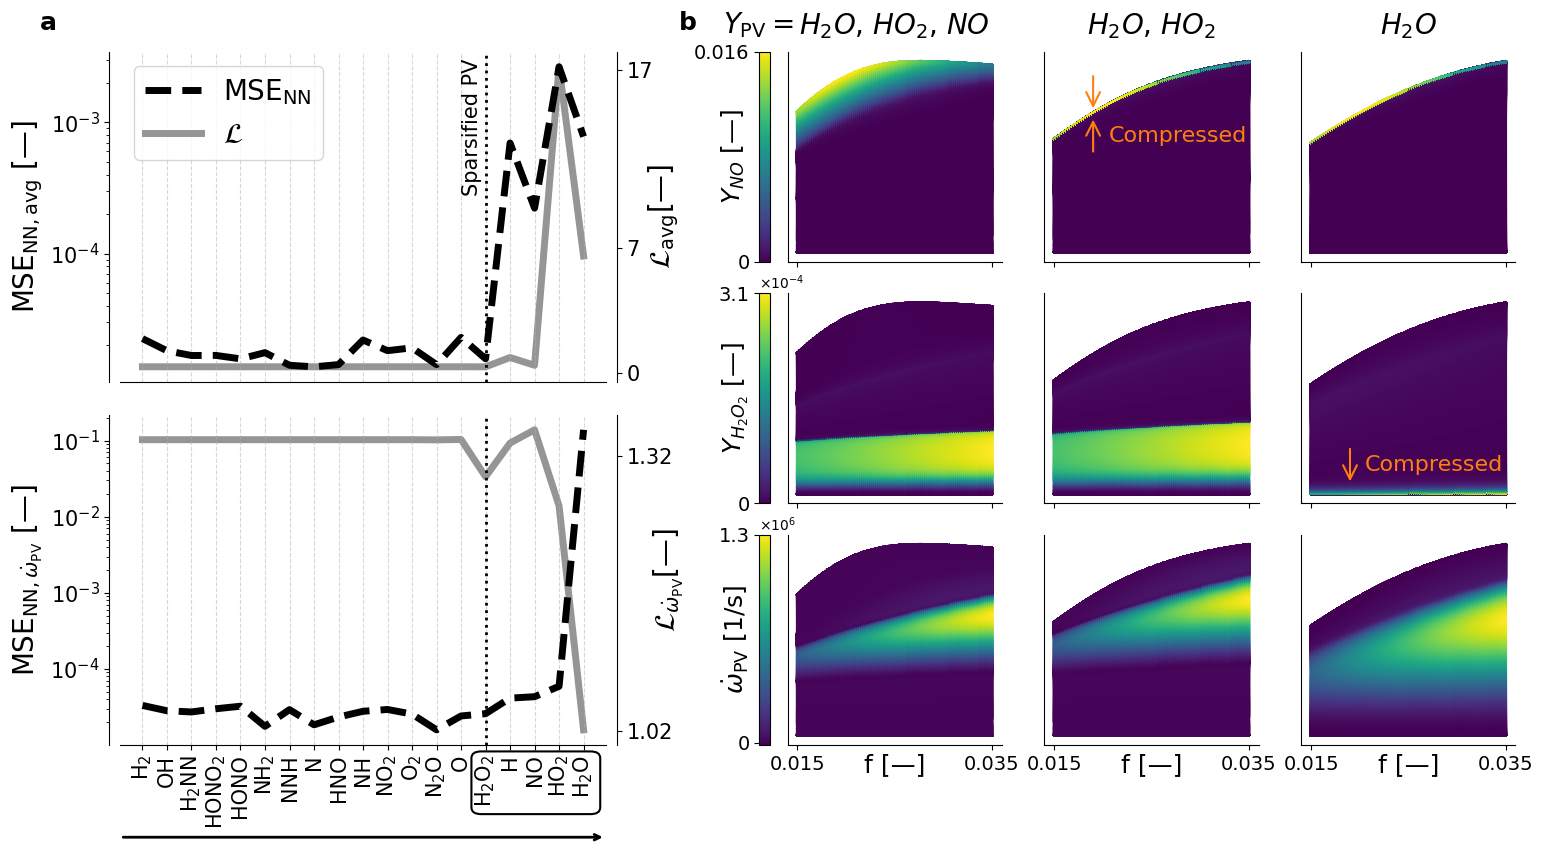

In [ ]:
save = True
pathSave = f"C:/Users/Admin/Documents/PhD-ULB/Figures/2024-PV-optimization/Paper/EnergyAndAI/"
nameSave = f"Figure 4 - PV sparsification"

fig = plt.figure(figsize=(18, 9))  # width ~18, height matches right 3x3 grid

# Main gridspec: 1 row, 2 columns
gs_main = fig.add_gridspec(1, 2, width_ratios=[1, 1.5], wspace=0.3)

path_metadata = "metadata/"
filename_species_names = "Xu-state-space-names.csv"
path_data = "data-files/"
path_state_0D = path_data + "Xu-state-space-autoignition.csv"

# =========================
# Left figure (fig2) → 2x1
# =========================
gs_left = gs_main[0, 0].subgridspec(2, 1, hspace=0.10)
ax1 = fig.add_subplot(gs_left[0, 0])
ax3 = fig.add_subplot(gs_left[1, 0])

latex_species_list = [s.replace('2', r'$_2$') for s in order_species_removed_0D]
latex_species_list = [s.replace('3', r'$_3$') for s in latex_species_list]

x_axis_species = np.arange(nbr_input_species, 0, -1)
clean = True
annotation = "with annotation"

ax1.plot(x_axis_species, MSE_NN_array_autoignition, 'k--', label="$\mathrm{MSE}_{\mathrm{NN}}$", linewidth=5)
ax1.set_ylabel('$\mathrm{MSE}_{\mathrm{NN, avg}}$ [\u2014]', fontsize=20)
ax1.tick_params(axis='y', labelsize = 15)
if(clean):
    ax1.tick_params(axis='x', labelsize=15)
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x*1e3)}'))
ax1.set_yscale('log')

greys = cm.get_cmap('Greys')

if(annotation == "with annotation"):
    ax1.annotate(
        "Sparsified PV",  # LaTeX-style text
        xy=(0.705, 0.98),  # Position: Left side, top y-axis limit
        xycoords='axes fraction',  # Coordinates relative to the axis (0-1)
        fontsize=15,  # Adjust size
        rotation = 90,
        ha='left',  # Align left
        va='top'  # Align top
    )

ymin, ymax = ax1.get_ylim()

ax1.set_xticks(range(1, len(latex_species_list) + 1))
ax1.set_xticklabels(latex_species_list[::-1], rotation=90)

if(annotation == "with annotation"):
    #vertical dotted line
    ax1.axvline(x=5, color='k', linestyle=':', linewidth=2) 


#For the frame around the x-ticks
# Get x-tick positions for ticks 0 to 7
tick_positions = ax1.get_xticks()[17:]  # Select the first 8 ticks
tick_labels = ax1.get_xticklabels()[17:]

#box around the selected species for the simplified PV
fig = plt.gcf()
renderer = fig.canvas.get_renderer()

first_label_bbox = tick_labels[0].get_window_extent(renderer).transformed(ax1.transAxes.inverted())
last_label_bbox = tick_labels[-1].get_window_extent(renderer).transformed(ax1.transAxes.inverted())

if(clean):
    ax1.tick_params(axis='x', bottom=False, labelbottom=False)

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(x_axis_species, cost_array_pow4_autoignition, color = greys(0.5), label=r'$\mathcal{L}$', linewidth=5) #_{\mathrm{avg}}
ax2.set_ylabel(r'$\mathcal{L}_{\mathrm{avg}}$' + '[\u2014]', fontsize=20, labelpad = -5)
ax2.tick_params(axis='y', labelsize = 15)
ax2.set_yticks([0, 7, 17])

ax1.set_zorder(ax2.get_zorder() + 1)
ax1.patch.set_visible(False)

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
leg = ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize = 20)
leg.set_zorder(10)

x_axis_species = np.arange(nbr_input_species, 0, -1)

latex_species_list = [s.replace('2', r'$_2$') for s in order_species_removed_0D]
latex_species_list = [s.replace('3', r'$_3$') for s in latex_species_list]

ax3.plot(x_axis_species, MSE_NN_PV_array_autoignition, 'k--', label="$\mathrm{MSE}_{NN}$", linewidth=5)
ax3.set_ylabel('$\mathrm{MSE}_{\mathrm{NN}, \dot{\omega}_{\mathrm{PV}}}$ [\u2014]', fontsize=20)
ax3.tick_params(axis='y', labelsize = 15)
ax3.tick_params(axis='x', labelsize=15)
ax3.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x*1e3)}'))
ax3.set_yscale('log')

ax3.set_xticks(range(1, len(latex_species_list) + 1))
ax3.set_xticklabels(latex_species_list[::-1], rotation=90)

if(annotation == "with annotation"):
    #vertical dotted line
    ax3.axvline(x=5, color='k', linestyle=':', linewidth=2) 


#For the frame around the x-ticks
# Get x-tick positions for ticks 0 to 7
tick_positions = ax3.get_xticks()[17:]  # Select the first 8 ticks
tick_labels = ax3.get_xticklabels()[17:]

#box around the selected species for the simplified PV
fig = plt.gcf()
renderer = fig.canvas.get_renderer()

first_label_bbox = tick_labels[0].get_window_extent(renderer).transformed(ax3.transAxes.inverted())
last_label_bbox = tick_labels[-1].get_window_extent(renderer).transformed(ax3.transAxes.inverted())

# Define the rectangle covering only the x-ticks from 0 to 7
rect = patches.FancyBboxPatch(
    (first_label_bbox.x0-0.14, -1.29),  # X start position & Y just below tick labels
    last_label_bbox.x1 - first_label_bbox.x0 +0.13,  # Width to cover tick labels 0-7
    0.15,  # Height (just enough to wrap the tick labels)
    boxstyle="round,pad=0.02",
    edgecolor="black",
    facecolor="none",
    linewidth=1.5,
    transform=ax1.transAxes,
    clip_on=False  # Ensures the frame stays in the tick label area
)

if(annotation == "with annotation"):
    # Add rectangle to the figure
    ax3.add_patch(rect)

ax3.annotate(
        "",  # Empty text
        xy=(1, -0.28),  # Arrow end (right side, below x-axis)
        xycoords='axes fraction',
        xytext=(0, -0.28),  # Arrow start (left side, below x-axis)
        textcoords='axes fraction',
        arrowprops=dict(arrowstyle="->", linewidth=2, color="black")
    )


# Create a second y-axis
ax4 = ax3.twinx()
ax4.plot(x_axis_species, costPV_array_pow4_autoignition, color = greys(0.5), label=r'$\mathcal{L}_{\dot{\omega}_{\mathrm{PV}}}$', linewidth=5)
ax4.set_ylabel(r'$\mathcal{L}_{\dot{\omega}_{\mathrm{PV}}}$' + '[\u2014]', fontsize=20, labelpad = -15)
ax4.tick_params(axis='y', labelsize = 15)
ax4.set_yticks([1.02, 1.32])

ax3.set_zorder(ax4.get_zorder() + 1)
ax3.patch.set_visible(False)

ax1.invert_xaxis()
ax3.invert_xaxis()

ax1.grid(axis='x', linestyle='--', alpha=0.5, zorder = 0)
ax3.grid(axis='x', linestyle='--', alpha=0.5, zorder = 0)

# Combine legends from both axes
lines_1, labels_1 = ax3.get_legend_handles_labels()
lines_2, labels_2 = ax4.get_legend_handles_labels()

for a in [ax1, ax3]:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)

for a in [ax2, ax4]:
    a.spines['top'].set_visible(False)
    a.spines['left'].set_visible(False)
    a.spines['bottom'].set_visible(False)

offset_left = 8
offset_right = 8
offset_bottom = 8

# Top subplot
ax1.spines['left'].set_position(('outward', offset_left))
ax2.spines['right'].set_position(('outward', offset_right))

# Bottom subplot
ax3.spines['left'].set_position(('outward', offset_left))
ax4.spines['right'].set_position(('outward', offset_right))

# =========================
# Right figure (fig3) → 3x3
# =========================
gs_right = gs_main[0, 1].subgridspec(3, 3, hspace=0.15, wspace=0.2)
axes_right = np.array([[fig.add_subplot(gs_right[i, j]) for j in range(3)] for i in range(3)])

keys = ['NO', 'H2O2','PV1']

nameCols = ["$H_2O$, $HO_2$, $NO$", "$H_2O$, $HO_2$", "$H_2O$"]

keysYaxis = [r"$Y_{NO}$"+ " [\u2014]", r"$Y_{H_2O_2}$"+ " [\u2014]",r"$\dot{\omega}_{\mathrm{PV}}$"+ " [1/s]"]

filename_model = "Xu-AE-opt_adam-epo_100000-lr_0.025-date_24Mar2025-hour_10h50_Tr0D-2s_s2" #"Xu-AE-opt_adam-epo_100000-lr_0.025-date_14Mar2025-hour_14h23_Tr0D-2q_s0"
filename_metadata = filename_model + "_metadata.pkl"
path_metadata = "metadata/"
filename_species_names = "Xu-state-space-names.csv"
path_data = "data-files/"

loader = loadData(filename_species_names, path_metadata, filename_metadata)
idx_species_removed = loader.metadata["list idx species removed source"] if loader.metadata["dataset_type"].startswith("autoignition_augm") else loader.metadata["idx species removed"]
id_model = loader.metadata["Training_id"]
model = loader.loadModel()
nbr_input_species = loader.metadata["nbr input species"]

weight_inversion = False
if(weight_inversion):
    with torch.no_grad():  # Ensures we do not track gradients for this operation
        model.encoder_species.weight.mul_(-1)


rows, cols = len(keys), 3
axes_right_flat = axes_right.flatten()
speciesToVisualize = [""]
idxAx = 0

for idxSpecies in range(nbr_input_species): #nbr_input_species):

    #Update the model with the threshold

    final_weights = copy.deepcopy(model.encoder_species.weight.detach().numpy()[0])

    if(model.auto_scaling):
        final_weights *= model.scaling_weights.detach().numpy()

    #get index spcies removed
    my_species = Species(path_data)

    #get mass fractions of species
    state_space_0D = read_csv(path_state_0D, header = "infer")
    state_space_0D = state_space_0D.drop(state_space_0D.columns[idx_species_removed], axis=1)
    state_space_matrix = state_space_0D.to_numpy()

    wi_Yi = state_space_matrix*np.abs(final_weights) #|w_i|*Y_i
    max_wi_Yi = np.max(wi_Yi, axis = 0) #take max of every species

    #selection of values greater than zero
    #CHECK that none of the weights in the PV is already zero!
    mask = max_wi_Yi > 0

    #Find the index with the minimum max wi Yi which is not zero
    index_species_min_max_wi_Yi = np.argmin(max_wi_Yi[mask])

    #Get the index back in the original array
    index_species_min_max_wi_Yi = np.where(mask)[0][index_species_min_max_wi_Yi]

    
    if(idxSpecies>0): #do not simplify for the first iteration to have the first value with all input species
        with torch.no_grad():
            model.encoder_species.weight[0,index_species_min_max_wi_Yi] = 0
            #order_species_removed.append(list_input_species[index_species_min_max_wi_Yi])

    dataset = "autoignition"
    state_space_names_DNS = np.genfromtxt(f"{path_data}Xu-state-space-names.csv", delimiter=",", dtype=str)
    state_space_train_DNS = state_space_train_0D[state_space_names_DNS].to_numpy()
    state_space_source_train_DNS = state_space_source_train_0D[state_space_names_DNS].to_numpy()
    PV_optimized_train_0D = model.get_PV(torch.from_numpy(np.delete(state_space_train_DNS, idx_species_removed, axis=1))).detach().numpy()
    PV_optimized_source_train_0D = model.get_PV(torch.from_numpy(np.delete(state_space_source_train_DNS, idx_species_removed, axis=1))).detach().numpy()


    if(idxSpecies >= nbr_input_species - 3):

        for idxKey, key in enumerate(keys):
            ax = axes_right_flat[idxAx + idxKey*3]

            if(key == "PV1"):
                colorSpecies = PV_optimized_source_train_0D
                colorName = "$PV_{source}$ [\u2014]"
            elif(key == "T"):
                colorSpecies = state_space_train_0D["T"]
                colorName = "T [K]"
            else:
                colorSpecies = state_space_train_0D[key]
                colorName = f"{key.replace('2', '$_2$')} [\u2014]"

            sc1 = ax.scatter(mixture_fractions_train_0D, PV_optimized_train_0D, c = colorSpecies, cmap = "viridis", s=1)
            if idxAx == 0:
                # create a separate axes for the colorbar
                cax = fig.add_axes([0.48, ax.get_position().y0, 0.006, ax.get_position().height])
                cbar = fig.colorbar(
                    sc1,
                    cax=cax,
                    orientation="vertical"
                )

                # Move ticks and label to the left
                cbar.ax.yaxis.set_ticks_position('left')
                cbar.ax.yaxis.set_label_position('left')
                
                # Label
                if idxKey == 0:
                    cbar.set_label(keysYaxis[idxKey], fontsize=18, labelpad=-38)
                else:
                    cbar.set_label(keysYaxis[idxKey], fontsize=18, labelpad=-23)
                cbar.ax.tick_params(labelsize=14)

                vmin = np.min(colorSpecies)
                vmax = np.max(colorSpecies)

                # Tick locations
                if idxKey == 2:
                    ticks = [0, vmax]
                else:
                    ticks = [vmin, vmax]
                cbar.set_ticks(ticks)

                # ================= FORMATTERS =================
                if idxKey == 0:
                    # ---- Plain decimal formatter (no scientific notation) ----
                    class PlainFormatter(mticker.Formatter):
                        def __call__(self, x, pos=None):
                            if np.isclose(x, 0):
                                return "0"
                            return f"{x:.3f}"

                    cbar.ax.yaxis.set_major_formatter(PlainFormatter())
                    cbar.ax.yaxis.offsetText.set_visible(False)  # hide ×10^n

                else:
                    # ---- Scientific formatter with 1 decimal + zero handling ----
                    class ZeroScalarFormatter(ScalarFormatter):
                        def _set_format(self):
                            self.format = "%1.1f"
                        def __call__(self, x, pos=None):
                            if np.isclose(x, 0):
                                return "0"
                            return super().__call__(x, pos)

                    formatter = ZeroScalarFormatter(useMathText=True)
                    formatter.set_powerlimits((0, 0))
                    cbar.ax.yaxis.set_major_formatter(formatter)
                    cbar.ax.yaxis.get_offset_text().set(size=10)

            ax.set_yticks([])
            if(idxKey == 0):
                ax.set_title(f"{nameCols[idxAx]}", fontsize=20, pad = 13)
            ax.set_xticks([0.015, 0.035])
            if(idxKey == len(keys)-1):
                ax.set_xlabel("f [\u2014]", fontsize = 18, labelpad = -15)
            else:
                ax.set_xticklabels([])
            ax.tick_params(axis = "x", labelsize=14)
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)
        idxAx += 1

        x_arrows = [0.019]

        # reference max value
        y_max = PV_optimized_train_0D.max()

# Bottom arrows (pointing upward)
y_start_bottom = 0.25 * y_max
y_end_bottom   = 0.05 * y_max

x_arrows_top = [0.019, 0.019]
arr_y_start_top = [0.52 * y_max, 0.95 * y_max]
arr_y_end_top = [0.72 * y_max, 0.75 * y_max]

for idxArrow, x in enumerate(x_arrows):
    # Bottom arrows
    axes_right[1, 2].annotate(
        "",
        xy=(x, y_end_bottom),
        xytext=(x, y_start_bottom),
        arrowprops=dict(
            arrowstyle="->",
            lw=1.5,
            color="tab:orange",
            mutation_scale=25
        )
    )

    if idxArrow == 0:
        y_text = 0.5 * (y_start_bottom + y_end_bottom)
        axes_right[1, 2].text(
            x + 0.0015,      # horizontal offset to the right
            y_text,
            "Compressed",
            va="center",
            ha="left",
            color="tab:orange",
            fontsize=16
        )

for idxArrow, x in enumerate(x_arrows_top):
    # Top arrows
    axes_right[0, 1].annotate(
        "",
        xy=(x, arr_y_end_top[idxArrow]),
        xytext=(x, arr_y_start_top[idxArrow]),
        arrowprops=dict(
            arrowstyle="->",
            lw=1.5,
            color="tab:orange",
            mutation_scale=25
        )
    )

    if idxArrow == 0:
        y_text = 0.5 * (arr_y_start_top[idxArrow] + arr_y_end_top[idxArrow])
        axes_right[0, 1].text(
            x + 0.00165,        # shift to the right
            y_text,
            "Compressed",
            va="center",
            ha="left",
            color="tab:orange",
            fontsize=16
        )

fig.text(
    x=0.46,                 # Horizontal position (close to the y-axis)
    y=0.91,                 # Vertical position (roughly same as column titles)
    s=r"$Y_{\mathrm{PV}} =$",        # LaTeX math formatting
    ha="left", va="center", # Align left and vertically center
    fontsize=20
)

# =========================
# Panel labels
# =========================
fig.text(0.08, 0.925, "a", fontsize=18, fontweight="bold", va="top", ha="left")  # left fig
fig.text(0.435, 0.925, "b", fontsize=18, fontweight="bold", va="top", ha="left")  # right fig

plt.tight_layout()
if save:
    plt.savefig(pathSave + nameSave + ".png", dpi=1000, bbox_inches="tight")
    #plt.savefig(pathSave + nameSave + ".pdf", bbox_inches="tight")
plt.show()